# Demonstration of using Hugging Face vision transformer with skorch

Based on this [blog post](https://huggingface.co/blog/fine-tune-vit), we show how with only a few lines of custom code, we can fine-tune a Vision Transformer model for a classification task.

In addition to installing torch and skorch, you need the `transformers` and `datasets` libraries:

    $ python -m pip install transformers datasets

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_VisionTranformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_VisionTranformer.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch transformers datasets

## Imports

In [2]:
import numpy as np
import torch
from datasets import load_dataset
from torch import nn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skorch import NeuralNetClassifier
from skorch.callbacks import ProgressBar, LRScheduler
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import LinearLR, LambdaLR

In [3]:
torch.manual_seed(1234)

## Load beans dataset

More details on the dataset can be found on [its datasets page](https://huggingface.co/datasets/beans). For our purposes, what's important is that we have image inputs and the target we're trying to predict is one of three classes for each image.

In [4]:
ds = load_dataset('beans')

Found cached dataset beans (/home/vinh/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
X = ds['train']['image']
y = np.array(ds['train']['labels'])

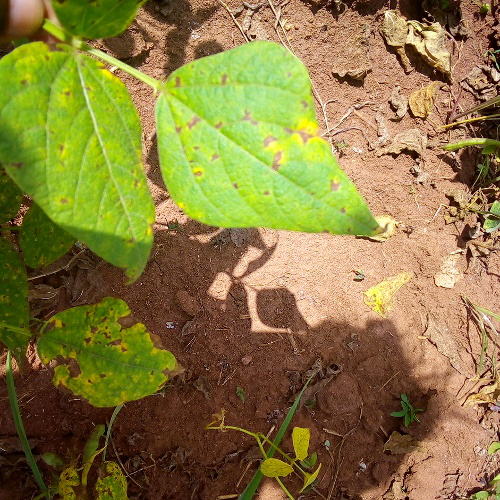

In [6]:
ds['train'][0]['image']

## Custom code

We wrap the vision transformer feature extractor into an sklearn `Transformer`. It doesn't do much more than loading the feature extractor and returning the pixel values of the features. It also takes care of setting the device.

The reason to have a separate step for the feature extractor is that it needs to be called on the images only once, given that the output is deterministic. If we would put it inside the `nn.Module`, we would call it on the same data once per epoch, which is wasteful.

In [7]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model_name, device='cpu'):
        self.model_name = model_name
        self.device = device

    def fit(self, X, y=None, **fit_params):
        self.extractor_ = ViTFeatureExtractor.from_pretrained(
            self.model_name, device=self.device,
        )
        return self

    def transform(self, X):
        return self.extractor_(X, return_tensors='pt')['pixel_values']

The vision transformer module itself is modified to return the logits.

In [8]:
class VitModule(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = ViTForImageClassification.from_pretrained(
            model_name, num_labels=num_classes
        )

    def forward(self, X):
        X = self.model(X)
        return X.logits

To stick close to the original blog post, we use the same learning rate schedule.

In [9]:
def make_lr_lambda(num_warmup_steps, num_training_steps, last_epoch=-1):
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return lr_lambda

## Training

### hyper parameters

In [10]:
vit_model = 'google/vit-base-patch32-224-in21k'
max_epochs = 4
batch_size = 16
optimizer = torch.optim.AdamW
learning_rate = 2e-4
weight_decay = 0.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### model pipeline

The model definition is straightforward. We use an sklearn `Pipeline` to chain the feature extractor and the model together. The model itself is a skorch `NeuralNetClassifier`, because we're dealing with a classification task. The module we need to pass to `NeuralNetClassifier` is the `VitModule` we defined above.

As always in skorch, to pass sub-parameters, we use the double-underscore notation. So e.g. to pass the number of classes argument, `num_classes`, to the module, we set `module__num_classes=3`.

The arguments used here are all fairly standard. Note that we use the `LRScheduler` callback from skorch to use the aforementioned learning rate schedule, and we add the `ProgressBar` callback too, which, as the name suggests, adds a progressbar.

To stick close to the blog post, we also set `train_split=False`, so that skorch uses the whole training data for training. By default, we would instead split a part of the training data for internal validation. But since the dataset already defines a validation split, this is not necessary.

In [11]:
pipe = Pipeline([
    ('feature_extractor', FeatureExtractor(
        vit_model,
        device=device,
    )),
    ('net', NeuralNetClassifier(
        VitModule,
        module__model_name=vit_model,
        module__num_classes=3,
        criterion=nn.CrossEntropyLoss,
        max_epochs=max_epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        optimizer__weight_decay=weight_decay,
        lr=learning_rate,
        device=device,
        iterator_train__shuffle=True,
        train_split=False,
        callbacks=[
            LRScheduler(LambdaLR, lr_lambda=make_lr_lambda(0.0, max_epochs)),
            ProgressBar(),
        ],
    )),
])

Now we're ready to train the model. As always, we just call `fit` with our training data. skorch will automatically show the progress bar and some training metrics like the train loss.

In [12]:
pipe.fit(X, y);

Some weights of the model checkpoint at google/vit-base-patch32-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/65 [00:00<?, ?it/s]

  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        0.4408  0.0002  9.2002


  0%|          | 0/65 [00:00<?, ?it/s]

      2        0.1459  0.0002  8.3028


  0%|          | 0/65 [00:00<?, ?it/s]

      3        0.0699  0.0001  9.2470


  0%|          | 0/65 [00:00<?, ?it/s]

      4        0.0321  0.0001  9.3720


## Evaluation

Finally, let's calculate accuracy on the predefined validation set of the dataset.

In [13]:
X_valid = ds['validation']['image']
y_valid = ds['validation']['labels']

In [14]:
y_pred = pipe.predict(X_valid)

In [15]:
print(f"Accuracy on validation dataset is {accuracy_score(y_valid, y_pred):.3f}")

Accuracy on validation dataset is 0.992


The accuracy is very high, we can be happy with the results 🤗